<b>Predicting  Students Exam Scores Across Different Subjects using KNN Regression and Linear Regression</b> 

<b>Introduction:</b>
Our project deals with how different factors may affect how well a student performs on an exam in various subjects as well as the relationship between all the subjects tested (math, reading, and writing). We were curious to know if the students seemed to perform well/poorly in only a specific subject or all three; thus, our goal is to find the answers to the following questions: 

- How strong is the correlation between writing scores and reading scores? What about reading scores  and math scores?
- Why may we expect to see these results?
- Could we accurately predict students’ writing exam score based on a student's reading exam score (%) using both KNN and linear regression model? If so, which of them is more accurate?

By answering these questions, we can further understand the effects of students’ socioeconomic background on their academic performances based on the grades secured by US highschool students in various subjects

Notes: 
- After our preliminary analysis we will choose the predictor with a stronger correlation to be used for the prediction models.
- All explained functions are denoted in quotations.



<b>Methods & Results:</b>
Using the K-nearest neighbor regression model and linear regression model, we will be predicting what a student's writing score would be on an exam, based on their reading exam score. We have broken our code down into various steps in order for the viewer to better understand how we solved this problem. 

In [1]:
#Loading Packages
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
library(rvest)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.1.3”
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ pars

Setting the Seed, Reading  and Cleaning the Data: 

The purpose of setting the seed is to make our data analysis reproducible.
Here, we read data directly from “URL” and provide “URL” to the function ‘read_csv’ as the path to the file. Since our project only deals with the students' exam scores, we filtered for only those columns, leaving out the other ones in order for the data set to be easier to read.

*Note: After transferring on open server, set.seed function did not work even after setting the seed in every code block that contains random analysis*

In [2]:
#Reading Data
url <- "http://roycekimmons.com/system/generate_data.php?dataset=exams&n=1000"
exam_data_full <- read_csv(url)
colnames(exam_data_full) <- c("gender", "race_ethnicity", "parental_level_of_education", "lunch", "test_preparation_course", "math_score", "reading_score", "writing_score")
set.seed(2000)
head(exam_data_full)

Rows: 1000 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): gender, race/ethnicity, parental level of education, lunch, test pr...
dbl (3): math score, reading score, writing score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
male,group C,high school,free/reduced,none,64,55,51
male,group E,some high school,standard,none,75,66,57
female,group E,high school,standard,completed,90,99,99
female,group C,some high school,standard,none,57,62,59
male,group B,associate's degree,free/reduced,none,58,61,53
male,group A,some college,standard,completed,74,68,72


<b>Table 1: Data from Student Exam Performance File<b>

In [3]:
exam_data <- exam_data_full |>
    select(math_score, reading_score, writing_score)
head(exam_data)

math_score,reading_score,writing_score
<dbl>,<dbl>,<dbl>
64,55,51
75,66,57
90,99,99
57,62,59
58,61,53
74,68,72


<b>Table 2: Student Exam Scores of Math, Reading and Writing<b>

Splitting the data into testing and training sets: 

We split the data into a training and testing set. The training set is what we will use to create our model and the testing set is what we will use at the end of our finalized model to make our prediction. We chose 75% of our original data set to be the training set and the remaining 25% to be the testing set.

In [4]:
set.seed(2000)
#Split
exam_split <- exam_data %>%
    initial_split(prop = 0.75, strata = writing_score)

In [5]:
#Assigning Training Data
exam_training <- exam_split %>%
  training()

In [6]:
#Assigning Testing Data
exam_testing <- exam_split %>%
  testing()

Analyzing the association between variables:

Using the ggpairs function allows us to produce a scatterplot from the selected variables  (writing_score vs. reading_score), along with a line graph of their distribution, and the correlation coefficient. The line graph shows that the data is  approximately normally distributed. Taking a look at the writing_score vs. math_score scatterplot, we can see that they are positively correlated with moderate strength (R-squared 0.654). Our other scatterplot, writing_score vs. reading_score shows us a positive correlation with high strength (R squared 0.901).  Since reading_score (x) explains more of the variation in writing_score (y)  than math_score can, we will be using it for our prediction models, KNN regression and simple linear regression. Based on all this information, we can conclude that using the variable "reading_score" to predict writing_score will result in a low RMSE, meaning a more accurate prediction of writing_score.


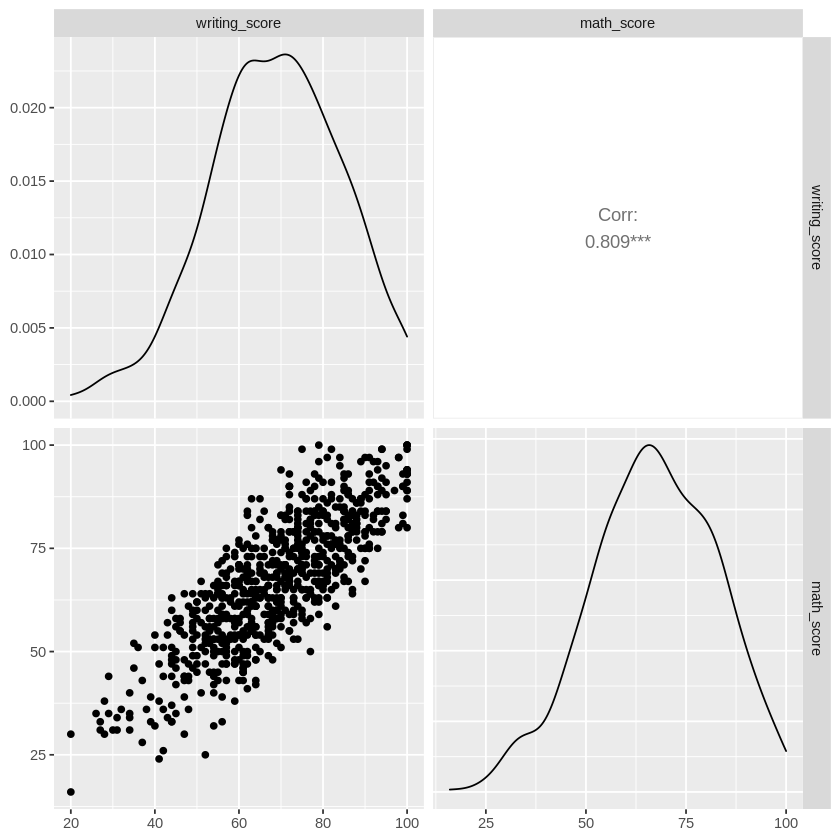

In [7]:
set.seed(2000)
exam_eda1 <- exam_training %>%
    select(writing_score, math_score) %>%
    ggpairs()
exam_eda1

<b>Figure 1: Scatterplot Matrix of Writing Score vs Math Score<b>

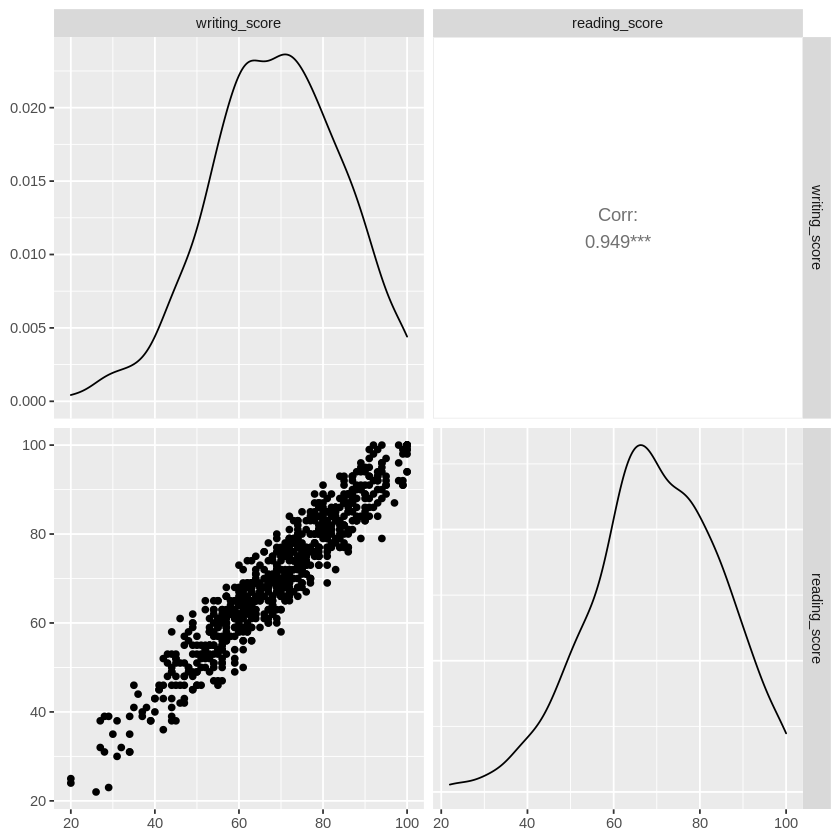

In [8]:
set.seed(2000)
exam_eda2 <- exam_training %>%
    select(writing_score, reading_score) %>%
    ggpairs()
exam_eda2

<b>Figure 2: Scatterplot Matrix of Writing Score vs Reading Score<b>

Applying K-NN Regression Model Specification:

Now that we have our optimal predictor, we will begin creating the KNN regression model. Setting the model  as “regression” lets our model know that we are dealing with the RMSPE for tuning and evaluation and makinga numerical prediction. We will set the ‘neighbors’ argument to equal the “tune” function since we don’t know the optimal K value to minimize RMSPE.

In [9]:
set.seed(2000)
#KNN Regression Model Specificiation
exam_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

Creating recipe with standardization:

Because K-nearest neighbor models are largely influenced by the scale of the predictors, we apply step_scale
and step_center to all of the predictor variables so that each of them have a mean of 0 and standard deviation of 1 to standardize our data. Using the standardized data, a recipe is created for the preprocessing of our data using our variables of interest, reading_score and writing_score.

In [10]:
set.seed(2000)
#Recipe with Standardization
exam_recipe <- recipe(writing_score ~ reading_score, data = exam_training) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

Cross Validation with 5 folds on training data:

We performed 5-fold  cross-validation to tune the KNN model and to help us choose the best k value. We set the 
strata argument to  writing_score to make sure the sampling proportion is equal for both the training and testing 
subsets. In cross validation, our training data is split into 5 chunks with same sizes, one of the chunks is used 
as validation set, and the other 4 chunks are combined to use as the training set. Cross-validation results in 
better estimate accuracy because our parameter choice now depends on multiple validation sets instead of only 1.

In [11]:
set.seed(2000)
#Cross Validation with 5 folds on training data
exam_vfold <- exam_training %>%
  vfold_cv(v = 5, strata = writing_score)

Creating workflow:

We create a workflow to chain the model and recipe together.

In [12]:
set.seed(2000)
#Creating workflow
exam_workflow <- workflow() %>%
  add_recipe(exam_recipe) %>%
  add_model(exam_spec)

Defining the tuning grid:

We ran cross-validation on a number of k values ranging from 1 to 200 in increments of 10.

In [13]:
set.seed(2000)
#Setting grid parameters
gridvals <- tibble(neighbors = seq(from = 1, to = 200, by = 10))

Collecting statistics from model:

The mean and standard error of the classifier's validation accuracy can be aggregated across folds by using the  collect_metrics function.

In [14]:
set.seed(2000)
#Collecting statistics from model
exam_results <- exam_workflow %>%
  tune_grid(resamples = exam_vfold, grid = gridvals) %>%
  collect_metrics()

Finding the minimum RMSE (mean value):

We use RMSE when predicting and evaluating prediction quality on the validation data. When the prediction is very close to the true value, the RMSPE value is small and  when the prediction is very far away from the true value, the RMSPE value is large, therefore we choose a K value that gives the minimum RMSPE value. The optimum K value is 21, which produces the smallest estimated RMSPE from cross-validation. 

In [15]:
set.seed(2000)
#Finding the minimum RMSE (mean value)
exam_min <- exam_results %>%
  filter(.metric == "rmse") %>%
  arrange(mean) %>%
  slice(1)
exam_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,rmse,standard,5.180643,5,0.1853478,Preprocessor1_Model03


<b>Table 3: Minimum RMSE Value<b>

In [16]:
#Assigning optimal K value to an object
k_min <- exam_min %>%
  pull(neighbors)

In [17]:
#Creating an object that only includes "rmse" in .metric (but with all data)
exam_results_cleanup <- exam_results %>%
  filter(.metric == "rmse")

Effect of the number of neighbors on the RMSPE:

According to the graph, the lowest RMSPE value, 5.181, occurs at K = 21. The RMSPE value is high when K value is between 0 and 10, the lowest RMSPE value occurs when K value is 20-30, then the RMSPE value increases as the value of K is larger. This is because when the K value is too small, our model is impacted too much by the training data. Due to its close adherence to training data, the model will not be able to predict new observations accurately, leading to large RMSPE values; this behavior is called overfitting. Oppositely, when the K value is too large,  our model is impacted too little by the training data since the prediction of new observation is just the average of the students’ writing score, also resulting in larger RMSPE; this behavior is called underfitting.





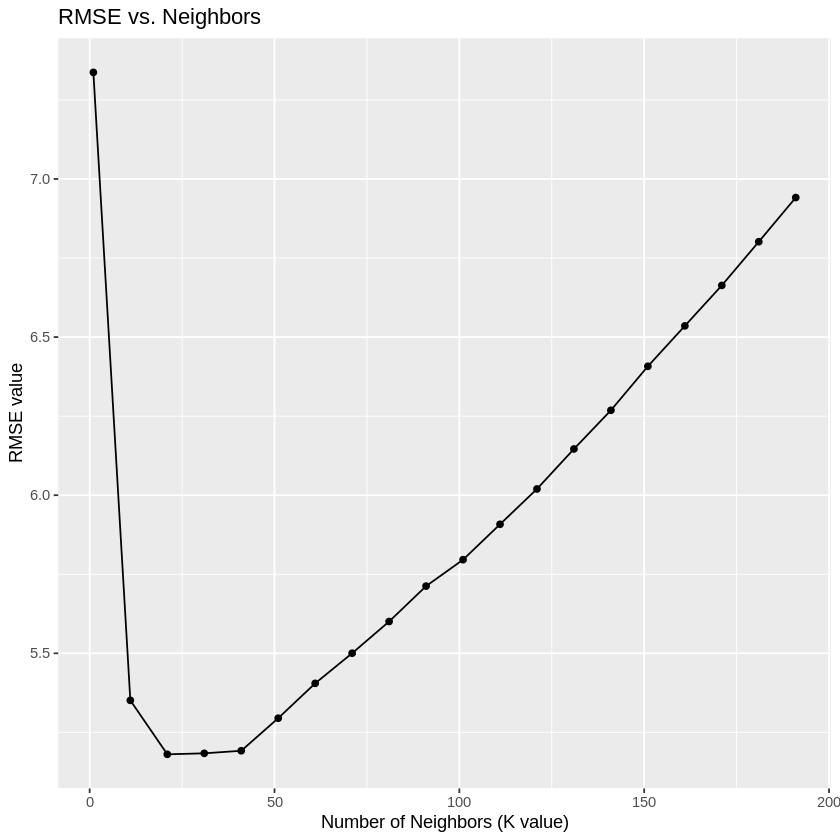

In [18]:
#Creating a plot with # of neighbors on x, rmse value on y.
rmse_plot <- exam_results_cleanup %>%
  ggplot(aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Neighbors (K value)", y = "RMSE value") +
  ggtitle("RMSE vs. Neighbors")
rmse_plot

<b>Figure 3: RMSE vs Neighbours<b>

Evaluating on the test set:

Using the test data, we want to assess our model’s RMSPE value to see how well it might perform on unseen data. We repeated the same steps from the above model specification and workflow, but this time using the optimum K, which is 21, to retrain our K-nearest neighbor regression model on the whole training data set. 

In [19]:
set.seed(2000)
#Making new model specification, but now with the optimal K value
exam_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
  set_engine("kknn") %>%
  set_mode("regression")

In [20]:
set.seed(2000)
#New workflow
exam_best_workflow <- workflow() %>%
  add_recipe(exam_recipe) %>%
  add_model(exam_best_spec) %>%
  fit(data = exam_training)

Making prediction:

After finalizing our model, we applied it to our testing data set to make our final prediction. We observed that our model's test error, as assessed by RMSPE, is 4.667%. This indicates that our model is capable of making a reasonably accurate prediction of a student's writing score based on their reading score.

In [21]:
set.seed(2000)
#Making prediction
exam_predict <- exam_best_workflow %>%
  predict(exam_testing) %>%
  bind_cols(exam_testing)

In [22]:
set.seed(2000)
#Getting metrics
exam_metrics <- exam_predict %>%
  metrics(truth = writing_score, estimate = .pred)
exam_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.6665563
rsq,standard,0.9105122
mae,standard,3.7419844


<b> Table 4: Final KNN Regression Model's Prediction Metrics <b>

Scatter plot with prediction line:

This scatter plot shows the predicted values of a student’s writing score for our final KNN regression model. As the cross-validation suggested, for the optimum K value 21, our model follows the general trend of the testing data but does not follow the disturbing swings between the data points, which shows that our model is likely to generalize well to new data sets.The blue line, which is our predicted values, becomes horizontal when the students’ reading scores and writing scores are both either below 35 or above 95. This is because there aren’t enough data points within these two ranges and our K value is larger than the sum of these data points in each range, therefore the predicted value is just the mean of these data points. Therefore, our model will accurately predict a student’s writing score if his/her reading score falls within the range 35 to 95, but it likely will not give accurate prediction of writing score if a student’s reading score falls out of this range due to the underfitting behavior.


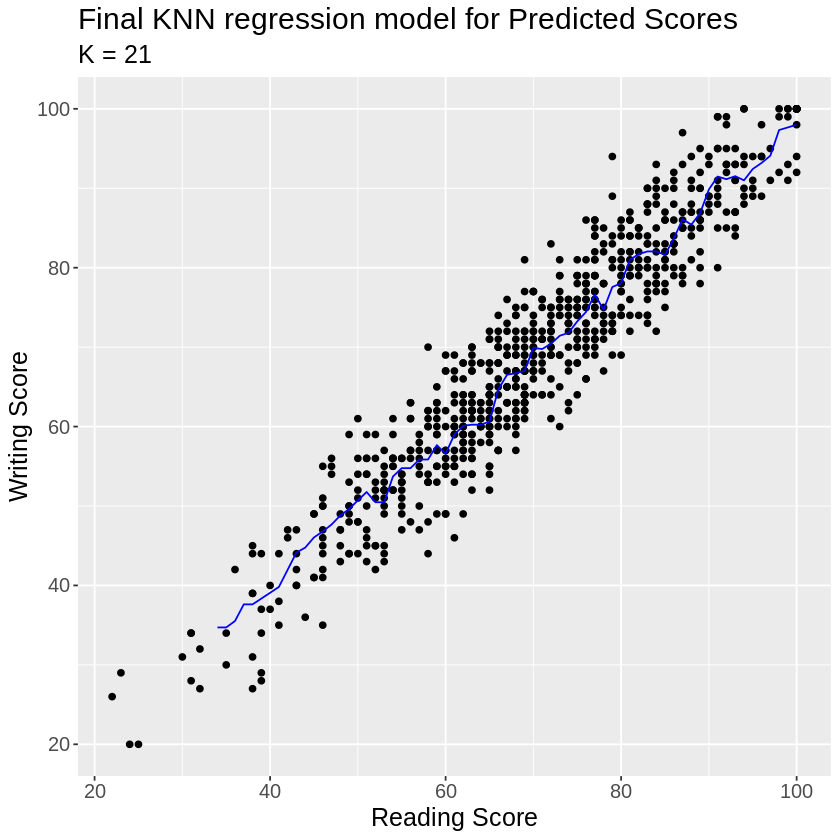

In [23]:
#Scatter plot with Y-predictions line.
predict_plot <- exam_training |>
    ggplot(aes(x = reading_score, y = writing_score)) +
    geom_point() +
    geom_line(data = exam_predict, mapping = aes(x = reading_score, y = .pred), color = "blue") +
    labs(x = "Reading Score", y = "Writing Score") +
    ggtitle("Final KNN regression model for Predicted Scores", paste0("K = ", k_min)) +
    theme(text = element_text(size = 15))
predict_plot

<b> Figure 4: Final KNN Regression Model for Predicted Scores <b>

Applying Linear Regression Model Specification:

Since the KNN regression model has limitations where it does not accurately predict beyond the range of the predictors in the training data, we provide an alternative model that is not affected by these limitations, Linear Regression. Similarly to KNN regression,  we begin by building a model specification. However,  we make slight changes to the code where we use the “linear_reg” function, set the engine to  “lm” and set the model to “regression”.

In [24]:
set.seed(2000)
#Linear Regression Model Specification
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

Recipe:

Using the training data set created from the previous model, we fit our variables of interest into a recipe. In our recipe, we do not need to standardize our data.

In [25]:
set.seed(2000)
#Recipe 
lm_recipe <- recipe(writing_score ~ reading_score, data = exam_training)

Creating workflow analysis:

Then, we create a workflow that contains our model specification and recipe as well as to fit in the training dataset. Our fitted simple linear regression model reveals the slope and coefficients for our predictors.

In [26]:
set.seed(2000)
#Creating Workflow and Determining Line of Best Fit
lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = exam_training)
lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
  (Intercept)  reading_score  
      0.03036        0.98400  


Assessing the Model:

We evaluate how well our model is by predicting on the testing set.

In [27]:
set.seed(2000)
#Assessing the Model
lm_test_results <- lm_fit |>
  predict(exam_testing) |>
  bind_cols(exam_testing) |>
  metrics(truth = writing_score, estimate = .pred)
lm_test_results
set.seed(2000)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.5579257
rsq,standard,0.9147491
mae,standard,3.6945544


<b> Table 4: Final Linear Regression Model's Prediction Metrics <b>

Calculating RMSPE:

After predicting on the test data set, we can extract the RMSPE and return a single numerical value of 4.558. Here, the RMSPE for the simple linear regression model is slightly lower than the RMSPE for the KNN regression model.

In [28]:
#Calculate RMSPE
lm_rmspe <- lm_test_results |>
          filter(.metric == "rmse") |>
          select(.estimate) |>
          pull()
lm_rmspe

[1] 4.557926

Scatter plot with prediction line:

This scatterplot illustrates the predicted values of a student’s writing score (blue line) for our Linear Regression Model. It allows us to assess the relationship between a student’s reading score and writing score. The slope of the blue line indicates how much the writing score is expected to increase with a one-unit increase in the reading score.

`geom_smooth()` using formula 'y ~ x'



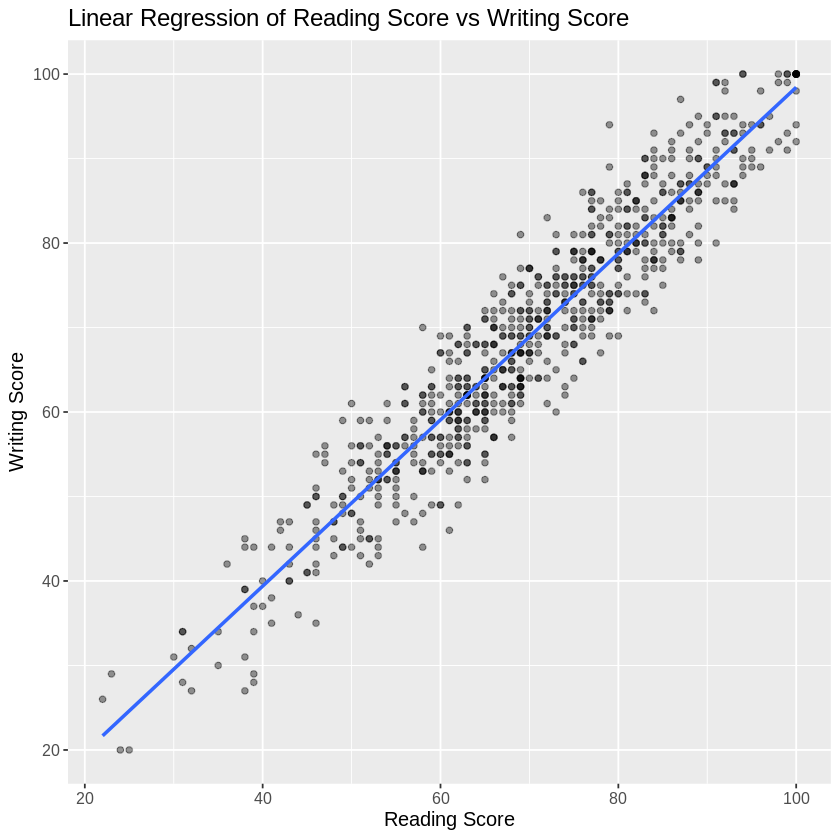

In [29]:
#Scatter plot with Line of Best Fit
lm_plot_final <- ggplot(exam_training, aes(x = reading_score, y = writing_score)) +
  geom_point(alpha = 0.4) +
  xlab("Reading Score") +
  ylab("Writing Score") +
  ggtitle("Linear Regression of Reading Score vs Writing Score")+
  geom_smooth(method = "lm", se = FALSE) + 
  theme(text = element_text(size = 12))
lm_plot_final

<b>Figure 5: Linear Regression of Reading Score vs Writing Score <b>

Comparison between the Scatterplots between Models:

Having the scatterplots for both regression models side by side allows to visualize both plots and compare the results. In the linear regression model, the line is completely straight while in KNN regression, the line is slightly more influenced by the individual data points so it appears more uneven. The issue with the prediction accuracy for the KNN regression model for reading scores out of the specified range is resolved as the linear model is able to extrapolate the data.


`geom_smooth()` using formula 'y ~ x'



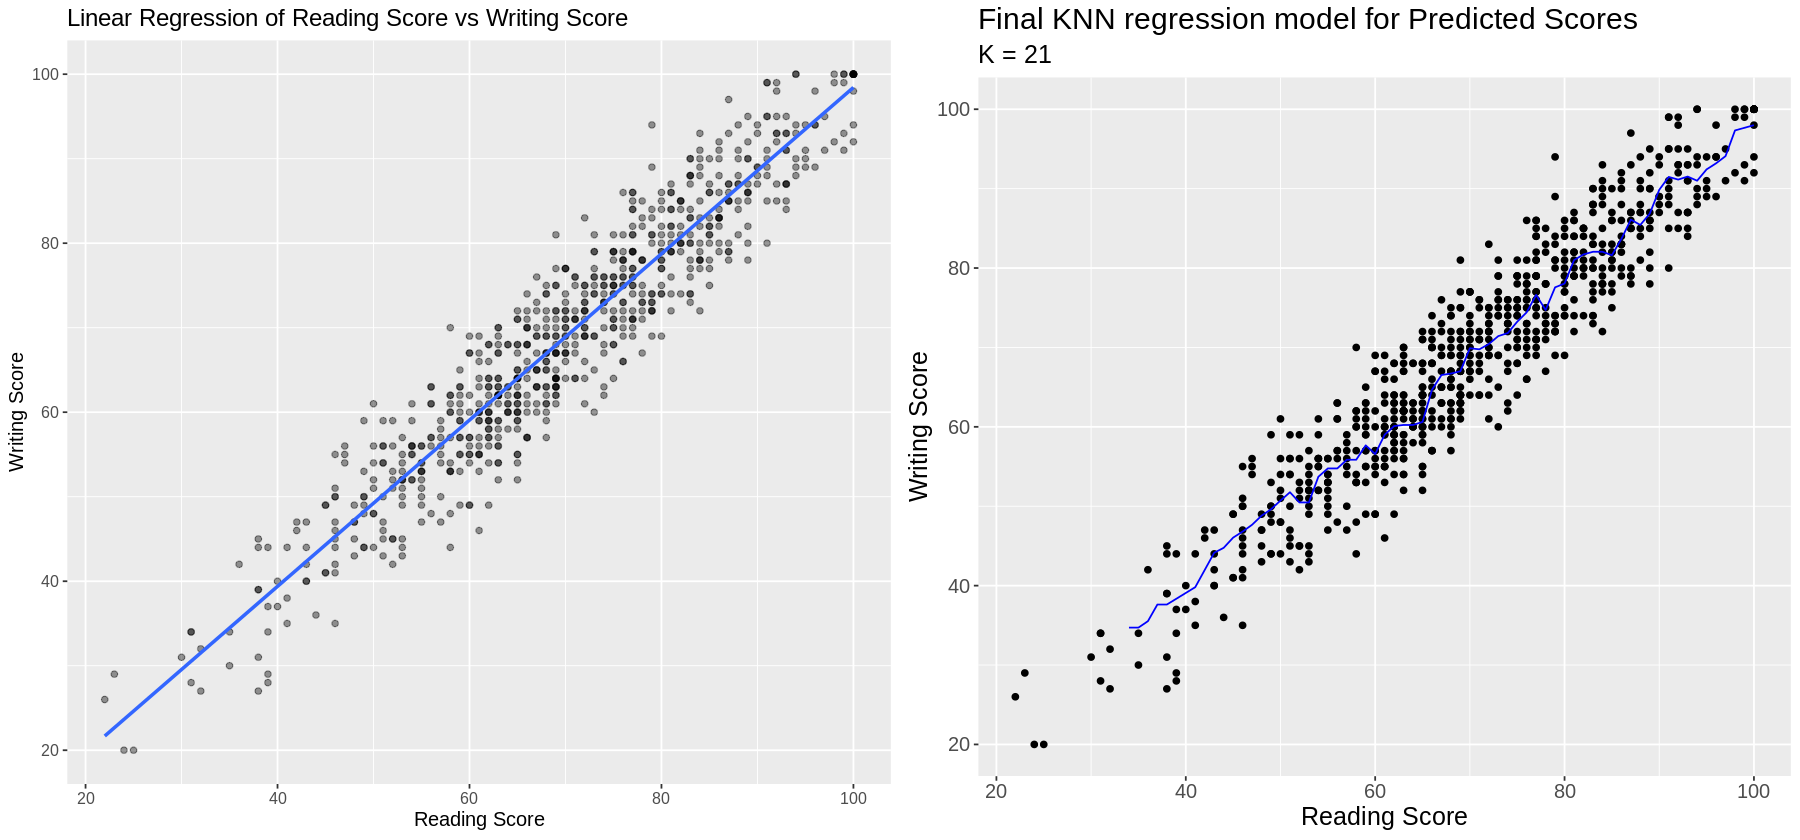

In [30]:
#Comparing Plots of Linear Regression and KNN-Regression Models
options(repr.plot.width = 15, repr.plot.height = 7)
plot_grid(lm_plot_final, predict_plot, ncol = 2)

<b> Figure 6: Linear Regression and KNN-Regression Model Scatterplots <b>

<b>Discussion/ Results:</b>
We have found a strong positive correlation between the reading and writing scores of students in the dataset using both the KNN regression and linear regression models. In our predictions, we were able to visualize the relationship between the two variables. This is indicated in both scatterplots, where the blue line that represents the predicted writing scores is generally linear and contains a positive slope. We then further assessed the predictive accuracy of both models by calculating their RMSPE to obtain their expected test errors. For our KNN regression model, we calculated the RMSE (5.181) to indicate how well our model could fit our data. Finding the optimal K value then revealed that our newly-determined RMSPE (4.) was lower than the RMSE, indicating that the prediction is closer in accuracy. For our simple linear regression model, the determined RMSPE was 4.558. The test error was reduced, making the linear regression model a slightly better predictive model. In observing the low RMSPE, we can confirm our final models as good predictors of our data where the true writing scores are closely correlated with the given reading scores. The correlation between the two scores is as expected due to the similarities of the two subjects. As per the National Council of Teachers of English, “when students receive writing instruction, their reading fluency and comprehension improve”. If we were to look at a student's math score and reading score we might not find them as similar because the subjects are very different, accounted for by the  correlation coefficient in our analysis. However, this could lead to interesting questions such as, if a student does well in one subject, is that due to them being  good at that particular subject or are there other factors that can influence how students perform on exams? Through further research, we can help students to well-roundedly excel in various subjects.

<b>References (APA format):</b>

Timbers, T., Campbell, T., & Lee, M. (2022, September 24). Data Science. Retrieved April 2023, from https://datasciencebook.ca/ 

Fink, L. (2018, October 12). The relationship between writing and reading. National Council of Teachers of English. Retrieved April 11, 2023, from https://ncte.org/blog/2017/12/relationship-writing-reading/ 

Seshapanpu, J. (2018, November 9). Students' performance in exams. Kaggle. Retrieved April 11, 2023, from https://www.kaggle.com/datasets/spscientist/students-performance-in-exams 
